In [48]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

Several helper functions that calculate some statistics and organize the data

In [100]:
# Calculate mid prices for each product
def calculate_mid_prices(df):
    # Assuming the highest bid and lowest ask are the best prices
    best_bid = df[['bid_price_1', 'bid_price_2', 'bid_price_3']].max(axis=1)
    best_ask = df[['ask_price_1', 'ask_price_2', 'ask_price_3']].min(axis=1)
    
    # Calculate mid price
    mid_price = (best_bid + best_ask) / 2
    return mid_price

def calculate_weighted_price(df):
    """
    Calculate weighted price based on bid and ask prices and volumes.
    
    The weighted price considers both price levels and their corresponding volumes
    to provide a more accurate representation of the market price.
    """
    # Calculate weighted bid price
    bid_price_weighted = (
        df['bid_price_1'] * df['bid_volume_1'] +
        df['bid_price_2'] * df['bid_volume_2'] +
        df['bid_price_3'] * df['bid_volume_3']
    ) / (df['bid_volume_1'] + df['bid_volume_2'] + df['bid_volume_3'])
    
    # Calculate weighted ask price
    ask_price_weighted = (
        df['ask_price_1'] * df['ask_volume_1'] +
        df['ask_price_2'] * df['ask_volume_2'] +
        df['ask_price_3'] * df['ask_volume_3']
    ) / (df['ask_volume_1'] + df['ask_volume_2'] + df['ask_volume_3'])
    
    # Calculate the final weighted mid price
    weighted_price = (bid_price_weighted + ask_price_weighted) / 2
    
    # Handle division by zero cases (when volumes are 0)
    weighted_price = weighted_price.fillna(calculate_mid_prices(df))
    
    return weighted_price

def load_multiple_days(root_path, round_num, start_day, end_day):
    """
    Load price data from multiple days and combine into a single dataframe.
    Adds a mid_price column and a continuous timestamp.
    """
    combined_data = []
    
    for day in range(start_day, end_day + 1):
        try:
            file_path = f'{root_path}/prices_round_{round_num}_day_{day}.csv'
            day_data = pd.read_csv(file_path, delimiter=';')
            
            # Add a timestamp column that's continuous across days
            day_data['global_timestamp'] = day_data['timestamp'] + (day * 1000000)  # Assuming each day has 1M timestamps
            
            combined_data.append(day_data)
            print(f"Loaded day {day} data: {len(day_data)} rows")
        except FileNotFoundError:
            print(f"Warning: Data for day {day} not found at {file_path}")
    
    # Combine all dataframes
    if combined_data:
        all_data = pd.concat(combined_data, ignore_index=True)
        all_data['mid_price'] = calculate_mid_prices(all_data)
        print(f"Combined dataframe has {len(all_data)} rows")
        return all_data
    else:
        print("No data was loaded")
        return None

def calculate_optimal_threshold(df, product, window_size=300, lookback=1000):
    """
    Calculate optimal trading threshold based on historical deviations 
    between mid prices and volume-weighted average prices (VWAP).
    
    Args:
        df: DataFrame containing market data
        product: The product symbol to analyze
        window_size: Size of the rolling window in seconds
        lookback: Number of data points to consider
    
    Returns:
        float: Dynamically adjusted threshold
    """
    # Filter data for the specified product
    product_data = df[df['product'] == product].copy()
    
    if len(product_data) == 0:
        print(f"No data found for product {product}")
        return 0.02  # Default threshold
        
    # Use the most recent lookback points if available
    if len(product_data) > lookback:
        product_data = product_data.iloc[-lookback:]
    
    # Calculate VWAP components - ensure proper volume calculation
    product_data['volume'] = product_data['bid_volume_1'].fillna(0) + product_data['ask_volume_1'].fillna(0)
    
    # Skip rows with zero volume to avoid division by zero
    product_data = product_data[product_data['volume'] > 0].copy()
    
    if len(product_data) < window_size:
        print(f"Not enough data points with volume for product {product}: {len(product_data)} < {window_size}")
        return 0.02  # Default threshold
    
    # Calculate price-volume product
    product_data['price_volume'] = product_data['mid_price'] * product_data['volume']
    
    # Calculate rolling VWAP
    rolling_volume = product_data['volume'].rolling(window=window_size, min_periods=1).sum()
    rolling_price_volume = product_data['price_volume'].rolling(window=window_size, min_periods=1).sum()
    
    # Avoid division by zero
    vwap = np.where(rolling_volume > 0, rolling_price_volume / rolling_volume, product_data['mid_price'])
    product_data['vwap'] = vwap
    
    # Calculate deviations - handle potential divide by zero
    product_data['deviation'] = np.where(
        product_data['vwap'] > 0,
        (product_data['mid_price'] - product_data['vwap']) / product_data['vwap'],
        0
    )
    
    # Remove NaN values
    valid_deviations = product_data['deviation'].dropna().values
    
    if len(valid_deviations) < 10:  # Need some minimum data to calculate meaningful statistics
        print(f"Not enough valid deviation points for product {product}: {len(valid_deviations)} < 10")
        return 0.02  # Default threshold
        
    # Apply exponential weighting to more recent deviations
    weights = np.exp(np.linspace(-1, 0, len(valid_deviations)))
    weights = weights / weights.sum()  # Normalize weights
    
    # Calculate absolute deviations for threshold
    abs_deviations = np.abs(valid_deviations)
    
    # Calculate weighted standard deviation of absolute deviations
    weighted_mean = np.sum(abs_deviations * weights)
    weighted_variance = np.sum(((abs_deviations - weighted_mean) ** 2) * weights)
    weighted_std = np.sqrt(weighted_variance)
    
    # Dynamic adjustment factor based on recent volatility
    # Use a more robust method that handles NaN values
    pct_changes = product_data['mid_price'].pct_change().fillna(0)
    recent_volatility = pct_changes.rolling(window=window_size, min_periods=1).std().iloc[-1]
    adjustment_factor = max(1, recent_volatility * 100)
    
    # Incorporate order book imbalance
    bid_volume = product_data['bid_volume_1'].iloc[-1]
    ask_volume = product_data['ask_volume_1'].iloc[-1]
    imbalance = abs(bid_volume - ask_volume) / (bid_volume + ask_volume) if (bid_volume + ask_volume) > 0 else 0
    
    # Final threshold calculation
    threshold = weighted_std * adjustment_factor * (1 + imbalance)
    
    # Add a minimum threshold in case calculations result in very small values
    threshold = max(threshold, 0.01)
    
    # Print diagnostic info
    print(f"Product: {product}")
    print(f"Weighted STD: {weighted_std:.6f}")
    print(f"Recent volatility: {recent_volatility:.6f}")
    print(f"Adjustment factor: {adjustment_factor:.2f}")
    print(f"Imbalance: {imbalance:.4f}")
    
    return threshold

In [103]:
curr_round = 1
root_path = f'Round {curr_round}'

# Extract into dataframe
data = load_multiple_days(root_path, curr_round, -2, 0)
print(f"optimal threshold for vwap {calculate_optimal_threshold(data, 'SQUID_INK')}")

Loaded day -2 data: 30000 rows
Loaded day -1 data: 30000 rows
Loaded day 0 data: 30000 rows
Combined dataframe has 90000 rows
Product: SQUID_INK
Weighted STD: 0.004282
Recent volatility: 0.000833
Adjustment factor: 1.00
Imbalance: 0.0000
optimal threshold for vwap 0.01


In [31]:
# Filter data for each stock
kelp = data[data['product'] == 'KELP'].copy()
squid_ink = data[data['product'] == 'SQUID_INK'].copy()

# Reset indices to ensure they're aligned
kelp.reset_index(drop=True, inplace=True)
squid_ink.reset_index(drop=True, inplace=True)

# Calculate mid prices
kelp['mid_price'] = calculate_mid_prices(kelp)
squid_ink['mid_price'] = calculate_mid_prices(squid_ink)

# Calculate weighted prices
kelp['weighted_price'] = calculate_weighted_price(kelp)
squid_ink['weighted_price'] = calculate_weighted_price(squid_ink)

stock1_mid_prices = kelp['mid_price']
stock2_mid_prices = squid_ink['mid_price']

In [ ]:
def calculate_vwap_spread(self, df, order_depth: OrderDepth, vwap, volatility_window=100):
    """Calculate VWAP spread for kelp price"""
    if len(order_depth.sell_orders) == 0 or len(order_depth.buy_orders) == 0:
        return None
    
    # Calculate current market spread
    best_ask = min(order_depth.sell_orders.keys())
    best_bid = max(order_depth.buy_orders.keys())
    market_spread = best_ask - best_bid
    mid_price = (best_ask + best_bid) / 2
    
    # Calculate recent price volatility
    recent_prices = [trade['mid_price'] for trade in df[-volatility_window:]]
    if len(recent_prices) > 1:
        returns = [(recent_prices[i] - recent_prices[i-1])/recent_prices[i-1] 
                for i in range(1, len(recent_prices))]
        volatility = np.std(returns) * np.sqrt(len(returns))
    else:
        volatility = 0.001  # Default volatility if not enough data
    
    # Calculate order imbalance
    bid_volume = sum(order_depth.buy_orders.values())
    ask_volume = sum(-v for v in order_depth.sell_orders.values())
    imbalance = (bid_volume - ask_volume) / (bid_volume + ask_volume) if (bid_volume + ask_volume) > 0 else 0

    # Calculate VWAP deviation
    vwap_deviation = abs(mid_price - vwap) / vwap if vwap > 0 else 0
    
    # Calculate base spread as a percentage of price
    base_spread = mid_price * 0.15

    # Adjust spread based on volatility, imbalance and VWAP deviation
    volatility_adjustment = 1 + (volatility * 10)  # Higher volatility = wider spread
    imbalance_adjustment = 1 - (imbalance * 0.5)   # Negative imbalance = wider spread for buys
    deviation_adjustment = 1 + (vwap_deviation * 2)  # Higher deviation = wider spread
    
    # Calculate asymmetric spreads for buy and sell
    if imbalance > 0:  # More buying pressure
        buy_spread = base_spread * volatility_adjustment * deviation_adjustment * 1.2
        sell_spread = base_spread * volatility_adjustment * deviation_adjustment * 0.8
    else:  # More selling pressure
        buy_spread = base_spread * volatility_adjustment * deviation_adjustment * 0.8
        sell_spread = base_spread * volatility_adjustment * deviation_adjustment * 1.2

    # Ensure minimum spread is at least half the market spread
    min_spread = market_spread / 2
    buy_spread = max(buy_spread, min_spread)
    sell_spread = max(sell_spread, min_spread)
    
    return buy_spread, sell_spread

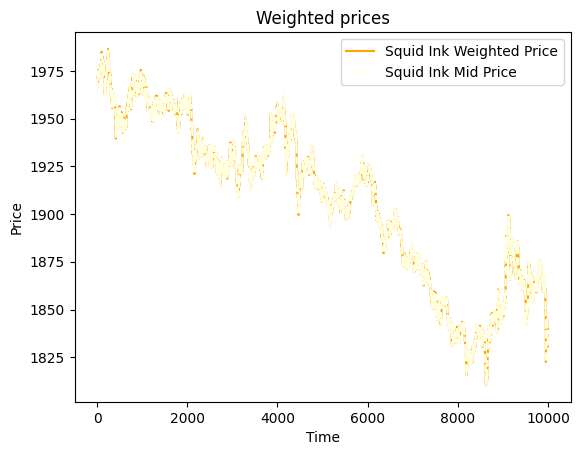

In [ ]:
fig, ax = plt.subplots()
ax.plot(kelp['weighted_price'], label='KELP Weighted Price', color='blue')
ax.plot(squid_ink['weighted_price'], label='Squid Ink Weighted Price', color='orange')
ax.plot(kelp['mid_price'], label='KELP Mid Price', linestyle='--', color='lightblue')
ax.plot(squid_ink['mid_price'], label='Squid Ink Mid Price', linestyle='--', color='lightyellow')
ax.set_title('Weighted prices')
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.legend()
plt.show()

In [ ]:
# Analysis of backtest results
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the backtest results
results_df = pd.read_csv('Round 1/backtest_results.csv')

# Display the top performing parameter combinations
print("Top 10 parameter combinations:")
print(results_df.sort_values('pnl', ascending=False).head(10))

# Basic statistics
print("\nSummary statistics:")
print(results_df['pnl'].describe())

# Create correlation matrix to see which parameters have the biggest impact
print("\nParameter correlations with PnL:")
correlations = results_df.corr()['pnl'].sort_values(ascending=False)
print(correlations)

In [ ]:
# Visualize parameter impact on performance
plt.figure(figsize=(15, 10))

# Create a grid of plots for each parameter
params = ['period', 'oversold', 'overbought', 'aggression_factor', 'low_buy', 'high_sell', 'buy_amount']
for i, param in enumerate(params):
    plt.subplot(3, 3, i+1)
    sns.scatterplot(data=results_df, x=param, y='pnl')
    plt.title(f'PnL vs {param}')
    plt.tight_layout()

plt.show()

# Find optimal parameter ranges
# Group by parameter and find average PnL for each value
param_impact = {}
for param in params:
    grouped = results_df.groupby(param)['pnl'].mean().reset_index()
    best_value = grouped.loc[grouped['pnl'].idxmax()][param]
    param_impact[param] = best_value
    
print("\nBest parameter values based on average PnL:")
for param, value in param_impact.items():
    print(f"{param}: {value}")

In [ ]:
# Interactive heatmap visualization for parameter interactions
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import interact, widgets

# Function to create heatmap of two parameters
@interact(
    param1=widgets.Dropdown(options=params, value='period'),
    param2=widgets.Dropdown(options=params, value='oversold')
)
def plot_heatmap(param1, param2):
    if param1 == param2:
        print("Please select two different parameters")
        return
    
    # Group by both parameters and calculate mean PnL
    pivot = results_df.pivot_table(
        values='pnl',
        index=param1,
        columns=param2,
        aggfunc='mean'
    )
    
    # Create heatmap
    fig = px.imshow(
        pivot,
        labels=dict(x=param2, y=param1, color="Average PnL"),
        title=f"Parameter interaction between {param1} and {param2}",
        color_continuous_scale="RdBu_r"
    )
    
    fig.show()
    
    # Find best combination
    best_idx = pivot.values.argmax()
    best_row, best_col = np.unravel_index(best_idx, pivot.shape)
    best_val1 = pivot.index[best_row]
    best_val2 = pivot.columns[best_col]
    best_pnl = pivot.values[best_row, best_col]
    
    print(f"Best combination: {param1}={best_val1}, {param2}={best_val2} with PnL={best_pnl:.2f}")